<a href="https://colab.research.google.com/github/Anas321/ImageCaptioning/blob/master/Image_captioning_inceptV3_MSCOCO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyyaml h5py  # Required to save models in HDF5 format

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/My Drive/Colab Notebooks/ImageCaptioning

/content/drive/My Drive/Colab Notebooks/ImageCaptioning


In [ ]:
pwd

'/content/drive/My Drive/Colab Notebooks/ImageCaptioning'

In [ ]:
ls

annotations/                                  model.png
cleaned_descriptions.json                     MODELS/
features_for_all_images_Inception_MSCOCO.pkl  tokenizer.pkl
Flickr/                                       train2014/
Image_captioning_inceptV3_MSCOCO.ipynb


In [ ]:
EXTRACT_IMAGES_FEATURES = 0
PROGRESSIVE_LOADING     = 1

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
# import collections
import random
import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle
from tqdm import tqdm

In [ ]:
# Download annotations files
annotations_url = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip'
annotations_folder_name = 'annotations'

if os.path.exists(os.path.abspath('') + '/' + annotations_folder_name):
  annotations_folder_path = os.path.abspath('') + '/' + annotations_folder_name
  print('annotations folder found!')
else:
  print('annotations file does not exit. Downloading it from source now...')
  annotations_zipped = tf.keras.utils.get_file(fname='annotations.zip',
                                                origin=annotations_url,
                                                extract=True)
  os.remove(annotations_zipped)
  annotations_folder_path = os.path.abspath('') + '/' + annotations_folder_name

annotations_file_path = os.path.abspath(annotations_folder_path) + '/captions_train2014.json' 
#annotations_file_train = os.path.abspath(annotations_folder) + '/annotations/captions_train2014.json'
print('annotations_file_path is:', annotations_file_path)

    

annotations folder found!
annotations_file_path is: /content/drive/My Drive/Colab Notebooks/ImageCaptioning/annotations/captions_train2014.json


In [ ]:
# Download images
images_url = 'http://images.cocodataset.org/zips/train2014.zip'
images_folder_name = 'train2014'

print(os.path.abspath('') + '/' + images_folder_name)

if os.path.exists(os.path.abspath('') + '/' + images_folder_name):
  images_folder_train_path = os.path.abspath('') + '/' + images_folder_name
  print('images folder found!')
  print('images_folder_train_path is:', images_folder_train_path)
else:
  # print('images folder does not exit. Downloading it from source now (warning: 13 GB)...')
  # images_zipped = tf.keras.utils.get_file(fname='train2014.zip',
  #                                               origin=images_url,
  #                                               extract=True)
  !wget 'http://images.cocodataset.org/zips/train2014.zip'
  ! unzip train2014.zip
  ! rm train2014.zip
# os.remove(images_zipped)
images_folder_train_path = os.path.abspath('') + '/' + images_folder_name

/content/drive/My Drive/Colab Notebooks/ImageCaptioning/train2014
images folder found!
images_folder_train_path is: /content/drive/My Drive/Colab Notebooks/ImageCaptioning/train2014


**Extract Images Features**

In [ ]:
from os import listdir
from pickle import dump
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Model
from tqdm import tqdm

images_folder_train = 'train2014'
all_images_features_file_name = 'features_for_all_images_Inception_MSCOCO.pkl'

# extract features from each image
def extract_images_features(directory):
    # load the VGG16 model
    model = InceptionV3()
    # re-structure the model
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    # print model summary
    print(model.summary())
    # define all_features dictionery to store 
    # features for all images
    all_features = dict()
    #counter = 1
    for name in tqdm(listdir(directory)):
        # get an image from a file
        filename = directory + '/' + name
        #print(filename)
        image = load_img(filename, target_size=(299,299))
        # convert the image pixles to a numpy array
        image = img_to_array(image)
        #print(image.shape)
        # reshape the created numpy array for the model
        image = image.reshape(1, image.shape[0], image.shape[1], image.shape[2])
        #print(image.shape)
        # prepare the image for the VGG16 model
        image = preprocess_input(image)
        # get features
        feature = model.predict(image, verbose=0)
        # get image id
        image_name = name.split('.')[0]
        #print(image_name)
        # store feature in the features dictionery
        all_features[image_name] = feature
        #print(counter,'>', name)
        #counter += 1
    return all_features

if EXTRACT_IMAGES_FEATURES == 1:
    # extract features from all images
    directory = images_folder_train
    features = extract_images_features(directory)
    print('Size of extracted features:', len(features))
    # save to file
    with open(all_images_features_file_name, 'wb') as f:
        pickle.dump(features, f)
#     dump(features, open('features_for_all_images_Inception_MSCOCO.pkl', 'wb'))

**Parse Annotations**

In [ ]:
import string
def parse_annotations(annotations_file_path, percentage_of_selected_images):
    # Load annotations json file
    with open(annotations_file_path, 'r') as f:
        file_content = json.load(f)
    # Create a dictionary where keys are the images ids and values are the captions
    desc_dict = dict()
    for val in file_content['annotations']:
        # Example of image name: COCO_train2014_000000282782.jpg
        image_id = 'COCO_train2014_' + '%012d' %(val['image_id']) #+ '.jpg'
        caption  = 'startseq ' + val['caption'] + ' endseq'
        if image_id not in desc_dict.keys():
            desc_dict[image_id] = list()
        desc_dict[image_id].append(caption)
    # select only percentage of the available images (for memory restrictions)
    if percentage_of_selected_images < 1.0:
        num_of_selected_images = round(len(desc_dict.keys())*percentage_of_selected_images)
        desc_dict = list(desc_dict.items())[0:num_of_selected_images]
        desc_dict = dict(desc_dict)
    # Loop through the desc_dict
    for key, desc_list in desc_dict.items():
        # Loop through the list for each key
        for i in range(len(desc_list)):
            current_desc = desc_list[i]
            # Tokenize; i.e., split
            current_desc = current_desc.split()
            # Lower case all words
            current_desc = [word.lower() for word in current_desc]
            # Remove any words with length <= 1
            current_desc = [word for word in current_desc if len(word)>1]
            # Remove any puctuations
            for j in range(len(current_desc)):
                current_word = current_desc[j]
                if not current_word.isalnum(): 
                    letters = list(current_word)
#                     print(letters)
                    letters = [letter for letter in letters if letter not in string.punctuation]
                    current_desc[j] = ''.join(letters)
#                     print(current_desc[j])
            # Remove any words happen to contain numbers in them
            current_desc = [word for word in current_desc if word.isalpha()]
            # Join the splitted words together again
            current_desc = ' '.join(current_desc)
            # Assain it back to the dictionery for its corresponding key
            desc_list[i] = current_desc
    # Print length of desc_dict
    print('There are {:d} images.'.format(len(desc_dict)))
    # Save the cleaned descriptions as a json file
    with open('cleaned_descriptions.json', 'w') as f:
        json.dump(desc_dict, f)
    print('\nCleaned descriptions are saved in \'cleaned_descriptions.json\' file.')
    
    return desc_dict


**Loading Images Features**

In [ ]:
def load_images_features(annotations_keys):
    print('\nLoading images features...')
    # Load pickled file 
    with open(all_images_features_file_name, 'rb') as f:
        all_images_features = pickle.load(f)
    # Create images features dictionary
    images_features = {key:all_images_features[key] for key in annotations_keys}
    print('Images features loaded!')
    single_image_features_shape = all_images_features[list(annotations_keys)[0]].shape
    print('Single image features shape is {}'.format(single_image_features_shape))
    return images_features

**Split Data Into Training and Validation**

In [ ]:
def split_data(annotations, images_features, train_split_percent):
    print('\nSplitting data...')
    # Split data into training and validation datasets
    train_set_size = round(len(annotations)*train_split_percent)
    valid_set_size = round(len(annotations)*(1-train_split_percent))
    print('train_set_size: {}'.format(train_set_size))
    print('valid_set_size: {}'.format(valid_set_size))
    # If sized do not sum up, print a warning
    if (train_set_size + valid_set_size == len(annotations)): pass
    else: print('Warning: train and valid sets sizes do not sum up to the whole dataset size!!!')
    # Shuffle images ids before splitting them
    images_ids = list(annotations.keys())
    random.shuffle(images_ids)
    # Split images ids
    train_images_ids = images_ids[:train_set_size]
    valid_images_ids = images_ids[train_set_size:]
    print('train_images_ids size :',len(train_images_ids))
    print('valid_images_ids size :',len(valid_images_ids))
    # Define empty lists
    captions_train = dict()
    captions_valid = dict()
    images_features_train = dict()
    images_features_valid = dict()
    # Loop for train
    for i in range(len(train_images_ids)):
        key = train_images_ids[i]
        if key not in captions_train.keys():
            captions_train[key] = list()
        captions_train[key].append(annotations[key])        
        if key not in images_features_train.keys():
            images_features_train[key] = list()
        images_features_train[key].append(images_features[key])
    # Loop for valid
    for i in range(len(valid_images_ids)):
        key = valid_images_ids[i]
        if key not in captions_train.keys():
            captions_valid[key] = list()
        captions_valid[key].append(annotations[key])
        if key not in images_features_valid.keys():
            images_features_valid[key] = list()
        images_features_valid[key].append(images_features[key])
    # Print info
    print('captions_train size       :', len(captions_train))
    print('images_features_train size:', len(images_features_train))
    print('captions_valid size       :', len(captions_valid))
    print('images_features_valid size:', len(images_features_valid))
    return captions_train, captions_valid, images_features_train, images_features_valid

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
def create_tokenizer(captions_train):
    # Convert captions_train from a dictionary to a list. This is needed for the following step.
    captions_train_list = list()
    captions_lengths = dict()
    unique_words = set()
    for key in captions_train.keys():
        for caption in captions_train[key][0]:
            captions_train_list.append(caption)
            # Save captions lengths, to calcualte the max_length
            if key not in captions_lengths.keys():
                captions_lengths[key] = list()
            captions_lengths[key].append(len(caption.split())-2)
            # Update unique_words set
            unique_words.update(caption.split())
    num_uniqe_words = len(unique_words)
    print('--------------------------')
    print('There are {} unique words in the training dataset.'.format(num_uniqe_words))
    key_max = max(captions_lengths, key=captions_lengths.get)
    print(key_max)
    max_length = max(captions_lengths[key_max])
    print('The longest caption is {} words length.'.format(max_length))
    # print(captions_train[key_max][0])
    # Create tokenizer 
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=num_uniqe_words, oov_token='<unk>')
    print('Tokenizer created!')
    print('--------------------------')
    # Fit tokenizer on training captions
    tokenizer.fit_on_texts(captions_train_list)
    # save the tokenizer. it will be needed later once the model is trained and loaded for testing.
#     print('Saving tokenizer to \'tokenizer.pkl\'')
    with open('tokenizer.pkl', 'wb') as f:
        pickle.dump(tokenizer, f)
    return tokenizer, num_uniqe_words, max_length
    

In [ ]:
from numpy import array
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

def create_sequences(captions, images_features, tokenizer, num_uniqe_words, max_length):
    # Define X1 (for image features), X2 (for input sequence), and y (for output sequence).
    X1 = list()
    X2 = list()
    y  = list()
    # Pad input sequences and one-hot-encode output sequences
    # for captions
    for key, captions_list in tqdm(captions.items(), desc='Creating training sequence'):
        for caption in captions_list[0]:
            seq = tokenizer.texts_to_sequences([caption])[0]
            for i in range(1,len(seq)):
                in_seq  = seq[:i]
                out_seq = seq[i]
                # Padding
                in_seq = tf.keras.preprocessing.sequence.pad_sequences([in_seq], maxlen=max_length)[0]
                out_seq = tf.keras.utils.to_categorical(y=[out_seq], num_classes=num_uniqe_words)[0]
                X1.append(images_features[key][0][0])
                X2.append(in_seq)
                y.append(out_seq)
    # Make them arrays
    X1 = array(X1) 
    X2 = array(X2, dtype='uint16') 
    y  = array(y, dtype='uint16')
    # print('X1.shape:',X1.shape)
    # print('X2.shape:',X2.shape)
    # print('y.shape :',y.shape)
    # print()
    return X1, X2, y

In [ ]:
def data_generator(captions, images_features, tokenizer,
                   num_uniqe_words, max_length, num_images_generated):
    # Define X1 (for image features), X2 (for input sequence), and y (for output sequence).
    X1 = list()
    X2 = list()
    y  = list()
    counter = 0
    # Pad input sequences and one-hot-encode output sequences
    # for captions
    while 1:
      for key, captions_list in captions.items():
        # print(key)
        counter+=1
        # print(counter)
        for caption in captions_list[0]:
          seq = tokenizer.texts_to_sequences([caption])[0]
          for i in range(1,len(seq)):
            in_seq  = seq[:i]
            out_seq = seq[i]
            # Padding
            in_seq = tf.keras.preprocessing.sequence.pad_sequences([in_seq], maxlen=max_length)[0]
            out_seq = tf.keras.utils.to_categorical(y=[out_seq], num_classes=num_uniqe_words)[0]
            X1.append(images_features[key][0][0])
            X2.append(in_seq)
            y.append(out_seq)
        if counter == num_images_generated:
        # Make them arrays
          # print('Number of required data generated!')
          X1 = array(X1) 
          X2 = array(X2, dtype='uint16') 
          y  = array(y, dtype='uint16')
          yield ([X1, X2], y)
          X1 = list()
          X2 = list()
          y  = list()
          counter = 0


In [ ]:
# def create_sequences_generator(captions_list, images_features, 
#                                tokenizer, num_uniqe_words, max_length):
#     # Define X1 (for image features), X2 (for input sequence), and y (for output sequence).
#     X1 = list()
#     X2 = list()
#     y  = list()
#     # Pad input sequences and one-hot-encode output sequences
#     # for captions
#     # for key, captions_list in tqdm(captions.items(), desc='Creating training sequence'):
#     for caption in captions_list[0]:
#         seq = tokenizer.texts_to_sequences([caption])[0]
#         for i in range(1,len(seq)):
#             in_seq  = seq[:i]
#             out_seq = seq[i]
#             # Padding
#             in_seq = tf.keras.preprocessing.sequence.pad_sequences([in_seq], maxlen=max_length)[0]
#             out_seq = tf.keras.utils.to_categorical(y=[out_seq], num_classes=num_uniqe_words)[0]
#             X1.append(images_features)#[key][0][0])
#             X2.append(in_seq)
#             y.append(out_seq)
#     # Make them arrays
#     X1 = array(X1) 
#     X2 = array(X2, dtype='uint16') 
#     y  = array(y, dtype='uint16')
#     # print('X1.shape:',X1.shape)
#     # print('X2.shape:',X2.shape)
#     # print('y.shape :',y.shape)
#     # print()
#     return X1, X2, y

In [ ]:
# def data_generator(captions, image_features, tokenizer, num_uniqe_words, max_length):
#   # loop for ever over images.
#   while 1:
#     for key, captions_list in captions.items():
#       # Get the image features
#       single_image_features = images_features[key][0]
#       print(key)
#       print('single_image_features.shape:',single_image_features.shape)
#       in_image, in_seq, out_word = create_sequences_generator(captions_list, 
#                                                               single_image_features,
#                                                               tokenizer, 
#                                                               num_uniqe_words, 
#                                                               max_length)
#       yield [[in_image, in_seq], out_word]

In [ ]:
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
# from tensorflow.keras.layers.merge import add
# from tensorflow.keras.layers.merge import concatenate
'''As of keras 2, the module keras.layers.merge doesn't have a generic public Merge-Layer. 
Instead you are supposed to import the subclasses like keras.layers.Add or keras.layers.Concatenate etc. 
directly (or their functional interfaces with the same names lowercase: keras.layers.add, 
keras.layers.concatenate etc.). See what types of merging layers exist in the keras docs'''


"As of keras 2, the module keras.layers.merge doesn't have a generic public Merge-Layer. \nInstead you are supposed to import the subclasses like keras.layers.Add or keras.layers.Concatenate etc. \ndirectly (or their functional interfaces with the same names lowercase: keras.layers.add, \nkeras.layers.concatenate etc.). See what types of merging layers exist in the keras docs"

In [ ]:
# define the captioning model
def define_model(vocab_size, max_length):
    # feature extractor model
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    # sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)
    # decoder model
    decoder1 = tf.keras.layers.add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam',    )
    # summarize model
#     print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [ ]:
# Parse annotations data
desc_dict = parse_annotations(annotations_file_path, 
                              percentage_of_selected_images=0.2)

# Load images features
images_features = load_images_features(desc_dict.keys())

# Split data 
captions_train, captions_valid, \
images_features_train, images_features_valid = split_data(desc_dict, 
                                                          images_features, 
                                                          train_split_percent=0.8)

# Create tokenizer
tokenizer, num_uniqe_words, max_length = create_tokenizer(captions_train)

vocabs_size = num_uniqe_words

There are 16557 images.

Cleaned descriptions are saved in 'cleaned_descriptions.json' file.

Loading images features...
Images features loaded!
Single image features shape is (1, 2048)

Splitting data...
train_set_size: 13246
valid_set_size: 3311
train_images_ids size : 13246
valid_images_ids size : 3311
captions_train size       : 13246
images_features_train size: 13246
captions_valid size       : 3311
images_features_valid size: 3311
--------------------------
There are 10398 unique words in the training dataset.
COCO_train2014_000000449712
The longest caption is 36 words length.
Tokenizer created!
--------------------------


In [ ]:
  # epochs = 20
  # batch_size_train = 100
  # batch_size_valid = 100
  # num_images_per_batch_train = round(len(captions_train)/batch_size_train)
  # num_images_per_batch_valid = round(len(captions_valid)/batch_size_valid)
  # steps_per_epochs_train = num_images_per_batch_train
  # steps_per_epochs_valid = num_images_per_batch_valid
  # print('Num. of training images  :',len(captions_train))
  # print('Num. of validation images:',len(captions_valid))
  # print('Num. of training images per batch  :',num_images_per_batch_train)
  # print('Num. of validation images per batch:',num_images_per_batch_valid)
  # print('num_epochs:', epochs)
  # print('steps_per_epochs_train:',steps_per_epochs_train)
  # print('steps_per_epochs_valid:',steps_per_epochs_valid)

In [ ]:
?model.fit

Object `model.fit` not found.


In [ ]:
import math
# batch size = 2,4,8,16, 32,64, 128,256,512,1024,2048,4096,8192,16384 (2^n)
if PROGRESSIVE_LOADING == 1:
  # Define model
  model = define_model(vocabs_size, max_length)
  # Define fitting hyperparameters
  epochs = 20
  batch_size = [128] #[16, 32, 64, 128, 256, 512, 1024]
  for BS in batch_size:
    batch_size_train = BS
    batch_size_valid = BS
    # num_images_per_batch_train = 7
    # num_images_per_batch_valid = 7
    # batch_size_train = math.ceil(len(captions_train)/num_images_per_batch_train)
    # batch_size_valid = math.ceil(len(captions_valid)/num_images_per_batch_valid)
    num_images_per_batch_train = round(len(captions_train)/batch_size_train)
    num_images_per_batch_valid = round(len(captions_valid)/batch_size_valid)
    # steps_per_epochs_train = num_images_per_batch_train
    # steps_per_epochs_valid = num_images_per_batch_valid
    print('Num. of training images  :',len(captions_train))
    print('Num. of validation images:',len(captions_valid))
    print('Num. of training images per batch  :',num_images_per_batch_train)
    print('Num. of validation images per batch:',num_images_per_batch_valid)
    print('Batch size train:',batch_size_train)
    print('Batch size valid:',batch_size_valid)
    print('Num. of epochs:', epochs)
    # print('steps_per_epochs_train:',steps_per_epochs_train)
    # print('steps_per_epochs_valid:',steps_per_epochs_valid)
    # Loop for fitting
    loss     = list()
    val_loss = list()
    for i in range(epochs):
      print('Epoch #',i+1)
      # Create the data generator
      generator_train = data_generator(captions_train, images_features_train,
                                       tokenizer, num_uniqe_words,
                                       max_length, num_images_per_batch_train)
    
      generator_valid = data_generator(captions_valid, images_features_valid,
                                       tokenizer, num_uniqe_words,
                                       max_length, num_images_per_batch_valid)
      # Fit for one epoch
      history = model.fit(x=generator_train, epochs=1, verbose=1,
                          steps_per_epoch=batch_size_train,
                          validation_data=generator_valid,
                          validation_steps=batch_size_valid,
                          max_queue_size=1, workers=1,
                          use_multiprocessing=False)
      
      loss.append(round(history.history['loss'][0],4))
      val_loss.append(round(history.history['val_loss'][0],4))
      # Save model
      model.save('MODELS/model_BS'+ str(batch_size_train) + '_EP' + str(i+1) + \
                      '_loss' + str(loss[i]) + '_val-loss' + str(val_loss[i]) + '.h5')

Num. of training images  : 13246
Num. of validation images: 3311
Num. of training images per batch  : 103
Num. of validation images per batch: 26
Batch size train: 128
Batch size valid: 128
Num. of epochs: 20
Epoch # 1
128/128 [==============================] - 76s 596ms/step - loss: 5.5737 - val_loss: 4.7139
Epoch # 2
128/128 [==============================] - 75s 584ms/step - loss: 4.2756 - val_loss: 3.9775
Epoch # 3
128/128 [==============================] - 74s 578ms/step - loss: 3.7499 - val_loss: 3.6968
Epoch # 4
128/128 [==============================] - 74s 580ms/step - loss: 3.4846 - val_loss: 3.5597
Epoch # 5
128/128 [==============================] - 75s 583ms/step - loss: 3.3105 - val_loss: 3.4902
Epoch # 6
128/128 [==============================] - 74s 579ms/step - loss: 3.1845 - val_loss: 3.4528
Epoch # 7
128/128 [==============================] - 74s 576ms/step - loss: 3.0859 - val_loss: 3.4295
Epoch # 8
128/128 [==============================] - 74s 577ms/step - loss: 3

KeyboardInterrupt: ignored

In [ ]:
if PROGRESSIVE_LOADING != 1:
  batch_size = 2**14
  print('batch size:', batch_size)
  epochs = 30
  # Define the model
  model = define_model(vocabs_size, max_length)
  # define checkpoint callback
  filepath = 'MODELS/' + 'model-' + 'batch_size' + str(batch_size) + \
    '-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
  # filepath = 'MODELS/model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
  checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
  # fit model
  history = model.fit(x=[X1_train, X2_train],
                      y=y_train,
                      batch_size=batch_size,
                      epochs=epochs, 
                      verbose=1, 
                      callbacks=[checkpoint], 
                      validation_data=([X1_valid, X2_valid], y_valid))

In [ ]:
min(history.history['val_loss'])

4.3020920753479

dict_keys(['loss', 'val_loss'])


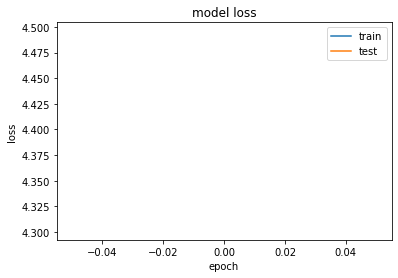

In [ ]:
import matplotlib.pyplot as plt

# list all data in history
print(history.history.keys())
# summarize history for loss
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper right')
# plt.yscale('log')
# plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()


In [ ]:
# map an integer to a word
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

# generate a description for an image
def generate_desc(model, tokenizer, image_features, max_length):
    # seed the generation process
    in_text = 'startseq'
    # iterate over the whole length of the sequence
    for i in range(max_length):
        # integer encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad input
        sequence = pad_sequences([sequence], maxlen=max_length)
        # predict next word
        yhat = model.predict([image_features, sequence], verbose=0)
        # convert probability to integer
        yhat = np.argmax(yhat)
        # map integer to word
        word = word_for_id(yhat, tokenizer)
        # stop if we cannot map the word
        if word is None:
            break
        # append as input for generating the next word
        in_text += ' ' + word
        # stop if we predict the end of the sequence
        if word == 'endseq':
            break
    return in_text

In [ ]:
# descriptions

In [ ]:
# # evaluate the skill of the model
# from nltk.translate.bleu_score import corpus_bleu

# actual = list() 
# predicted = list()
# # step over the whole set
# for key, desc_list in tqdm(captions_valid.items()):
#     # generate description
#     yhat = generate_desc(model, tokenizer, images_features_valid[key][0], max_length)
#     # store actual and predicted
# #     print(desc_list[0])
#     references = [d.split() for d in desc_list[0]]
#     actual.append(references)
#     predicted.append(yhat.split())
# # calculate BLEU score
# print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
# print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
# print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
# print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

In [ ]:
# evaluate the skill of the model
from nltk.translate.bleu_score import corpus_bleu

def evaluate_model(model, descriptions, images_features, tokenizer, max_length):
    actual, predicted = list(), list()
    # step over the whole set
    for key, desc_list in descriptions.items():
        # generate description
        yhat = generate_desc(model, tokenizer, images_features[key][0], max_length)
        # store actual and predicted
        references = [d.split() for d in desc_list]
        actual.append(references)
        predicted.append(yhat.split())
    # calculate BLEU score
    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

In [ ]:
from keras.models import load_model
# load the model
filename = 'model-ep002-loss3.245-val_loss3.612.h5'
model = load_model(filename)
evaluate_model(model, captions_valid, images_features_valid, tokenizer, max_length)

SyntaxError: ignored